In [1]:
%ls

import os, sys, glob, tqdm
import numpy as np
import mdtraj as md
from pymbar import MBAR
from pymbar import timeseries

print(os.getcwd())

# Spiroligomer projects contain 20 runs {0..19} which use umbrella sampling to pull
# a ligand (initially unbound in solution) towards MDM2. These umbrellas run from 0.1nm
# to 2.0nm with steps of 0.1nm. There are currently no unbiased ensembles, scaling of umbrella
# potentials, or runs intiated from a bound site (bound state unknown).

# I realize I am not doing any subsampling right now, which should be implemented. I'm working 
# on that in the time being as well as starting extra runs on FAH for the project. One will be
# the unbiased ensemble, and then some scaling kspring_k down from 200. 

# Questions:
# Should kspring_k be scaled down just on the closest umbrella, farthest umbrella, both?
# Should there be unbiased ensembles starting from both bound and unbound states?
# Without subsampling, should u_kln = np.zeros([K,L,N_min], np.float64) instead of N_max, so
# that runs of different size can be brought together?

# Following that, should u_kln[k,l,0:N_k[k]] = np.zeros([0:N_min]) if k = l? That is, the 
# difference between the potential for snapshot n from ensemble k and ensemble l should be
# 0 since k and l are the same ensemble.

# When calculating u_kln, do we need u_kln and u_lkn, or is this inefficient? It seems that
# right now we are calculating all combinations of k and l.

# As you will see below, I have successfully run MBAR using these constraints (although much
# to the dismay of my RAM without subsampling. If you run this, I would suggest striding the 
# data before calling MBAR), and generated a
# pmf, but I think I'll need to add the aforementioned ensembles and figure out how to run it
# with ensembles of different sizes, AND add a subsampling routine before I can really trust
# any results.


COM_Umbrella_MBAR.ipynb
/home/tug27224/packages/yabmtm/voelzmeister/spiroligomer_umbrellas/p14101


In [2]:
# setting parameters for the workflow to follow...

# denote run indices
run_indices = range(20)
# these runs represent the ensembles: lam = false, d = {0.1, 2.0, 0.1}

# denote number of ensembles
K = len(run_indices)
L = K

# kspring_k is the harmonic potential spring constant (in kJ/mol/nm^2) for eack ensemble
kspring_k = [200.0] * K
u_min = [0.1+0.1*k for k in range(K)]

# Keep track of WHAT distance(s) is/are being restrained in each ensemble
restrained_distance_indices = [[[555,'COM']]]*K
restrained_distance_labels = ['d555-ligand_COM']*K

# For this analysis, we will use only the 300K data
temperature = 300.0 # in K

# T_k is the temperature of each of the K ensembles
T_k = np.ones(K,float)*temperature

# beta is the inverse temperatures of each ensemble
kB = 1.381e-23 * 6.022e23 / 1000.0 # Boltzmann constant in kJ/mol/K
beta = 1.0 / (kB * temperature) # inverse temperature of simulations (in 1/(kJ/mol))


In [3]:
# this is useful for umbrella simulations that use COM of ligand as 
# restraint point instead of a single atom.

def compute_center_of_mass(traj, atom_indices=None):
    """Compute the center of mass for each frame.
    Parameters
    ----------
    traj : Trajectory
        Trajectory to compute center of mass for
    atom_indices : list of int
        Atoms to compute center of mass for. If None,
        will compute over all atoms
    Returns
    -------
    com : np.ndarray, shape=(n_frames, 3)
         Coordinates of the center of mass for each frame
    """

    if atom_indices is None:
        atoms = traj.top.atoms
        coords = traj.xyz
    else:
        atoms = [traj.top.atom(i) for i in atom_indices]
        coords = np.take(traj.xyz, atom_indices, axis=1)

    com = np.zeros((traj.n_frames, 3))
    masses = np.array([a.element.mass for a in traj.top.atoms])
    masses = np.array([a.element.mass for a in atoms])
    masses /= masses.sum()

    #for i, x in enumerate(traj.xyz):
    for i, x in enumerate(coords):
        com[i, :] = x.astype('float64').T.dot(masses)
    return com

In [5]:
# here we are writing .dat files for each run. these look the same as si's, but only have
# columns for n_clone, time(ns), and one distance compared to si's several distances.

PROJid = '14101'
path = '/media/tug27224/methuselah1/new1/TRAJECTORIES/PROJ%s'%PROJid
custom_residues = ['1MQ','20Q','20U','I18','I31','NUT','YIN','K23']
custom_residues += ['B1A','B1B','B2A','B2B','B2C','B2D','B2E','B3A','B3B']
custom_residues += ['B4A','B4B','B4C','B4D','B5A','B5B','B5C','B6A']

for run in range(len(run_indices)):
    distances = []
    f = open('run_%d_dists.dat'%run_indices[run],'a')
    f.write('#clone\ttime(ns)\t%s\n'%restrained_distance_labels[run])
    
    traj_files = sorted(glob.glob(path + '/P%s_R%d_*'%(PROJid,run_indices[run])))
    
    for j in tqdm.tqdm_notebook(range(len(traj_files))):
        traj = md.load(traj_files[j], top='%s.gro'%PROJid)
        ligand_indices = [a.index for a in traj.topology.atoms if a.residue.name in custom_residues]
        ligand_COM = compute_center_of_mass(traj,ligand_indices)
        protein_xyz = np.take(traj.xyz, [555], axis=1)

        for k in range(len(traj)):
            distance_between_groups = np.sqrt((ligand_COM[k][0] - protein_xyz[k][0][0])**2 +
                                (ligand_COM[k][1] - protein_xyz[k][0][1])**2 +
                                (ligand_COM[k][2] - protein_xyz[k][0][2])**2)
            distance_from_equil = np.abs(distance_between_groups - u_min[run])
            
            f.write('%d\t%f\t%f\n'%(j,0.1+ 0.1*k,distance_from_equil))
    f.close()
    

## Step 1.  Let's look at the raw distance data

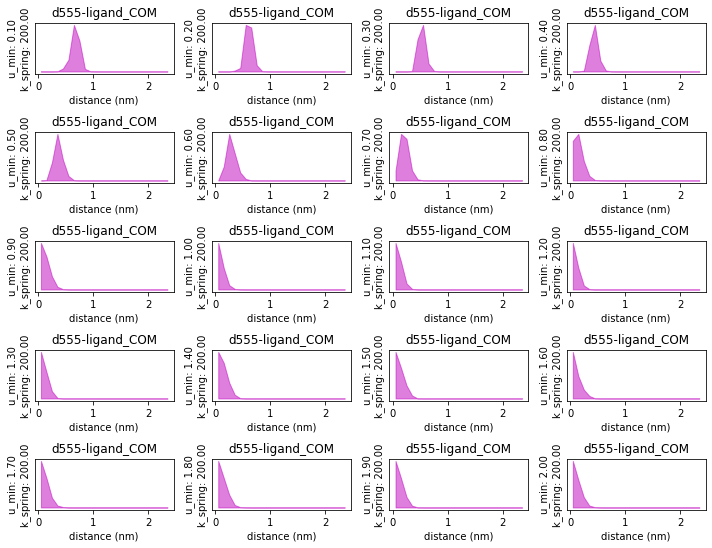

In [6]:
# For each RUN, lets look at the distrbution of the distances

from matplotlib import pyplot as plt
%matplotlib inline

# each input file has columns:
# clone	time(ns)	dist_7-116	dist_7-183	dist_7-208	dist_7-215
column_labels = ['clone', 'time(ns)', 'd555-ligand_COM']
colors = {'None':'k', 'd555-ligand_COM':'m'}
indir = '.'
plt.figure( figsize=(10,30) )
panel = 1
mybins = np.arange(0., 2.5, 0.1)
for i in range(K):
    run = run_indices[i]
    infile = os.path.join(os.path.abspath(indir),'run_%d_dists.dat'%run)
    data = np.loadtxt(infile)
    for j in [2]:  # column indices for each distance
        counts, bin_edges = np.histogram(data[:,j], bins=mybins)
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
        plt.subplot(K,4,panel)
        plt.fill_between(bin_centers, counts, np.zeros(counts.shape), color=colors[restrained_distance_labels[i]], alpha=0.5)
        plt.xlabel('distance (nm)')
        plt.yticks([])
        plt.title(column_labels[j])
        if j==2:
            plt.ylabel('u_min: %.2f\nk_spring: %.2f'%(u_min[i],kspring_k[i]))
        panel += 1
plt.tight_layout()
plt.show()

## Step 2. Prepare the data for input to MBAR

### 2.1 subsample the data to remove time-correlations

MBAR (like other free energy estimators such as WHAM) assumes that samples are drawn from each thermodynamic ensemble at thermal equilibrium.  Any time-correlated data is *statistically inefficient* and will bias the results.  The authors of MBAR provide several tools in `pymbar.timeseries` to deal with this, which essentially compute the autocorrelation time $\tau_c$ of some observable, and subsample data every $2\tau_c$.  In theory, this is great, but in *practice*, this can sometimes pare down your samples much too sparsely.  If possible, I recommend using all the data, and then seeing how subsampling effects the results.  Of course, some datasets (especially from Folding@home) are simply too large to efficiently calculate free energies using MBAR. In this case, subsampling can be a huge help.

For now, we will **ignore** subsampling, and proceed with our (test) dataset.

### 2.2 construct the `u_kln` matrix of energies

The `pymbar.MBAR()` class expects data in one of two forms:

```
 |      ----------
 |      u_kn : np.ndarray, float, shape=(K, N_max)
 |          ``u_kn[k,n]`` is the reduced potential energy of uncorrelated
 |          configuration n evaluated at state k.
 |      u_kln : np.ndarray, float, shape (K, L, N_max)
 |          if the simulation is in form ``u_kln[k,l,n]`` it is converted to ``u_kn`` format
 |      
 |          u_kn = [ u_1(x_1) u_1(x_2) u_1(x_3) . . . u_1(x_n)
 |                   u_2(x_1) u_2(x_2) u_2(x_3) . . . u_2(x_n)
 |                                              . . .
 |                   u_k(x_1) u_k(x_2) u_k(x_3) . . . u_k(x_n)]
 |      
 |      N_k :  np.ndarray, int, shape=(K)
 |          ``N_k[k]`` is the number of uncorrelated snapshots sampled from state ``k``.
 |          Some may be zero, indicating that there are no samples from that state.
 |      
 |          We assume that the states are ordered such that the first ``N_k``
 |          are from the first state, the 2nd ``N_k`` the second state, and so
 |          forth. This only becomes important for BAR -- MBAR does not
 |          care which samples are from which state.  We should eventually
 |          allow this assumption to be overwritten by parameters passed
 |          from above, once ``u_kln`` is phased out.

```

For now, let's try to build an array of reduced energies in the `u_kln` form...

In [7]:
# First let's compute the lengths of all the trajectories

# N_k is the number of trajectory snapshots sampled in each enesmble 
N_k = np.zeros([K], dtype = int)   # make an empty array for now
for i in range(K):
    run = run_indices[i]
    infile = os.path.join(os.path.abspath(indir),'run_%d_dists.dat'%run)
    N_k[i] = np.loadtxt(infile).shape[0]

print('N_k', N_k)
N_min = np.min(N_k)
N_max = np.max(N_k)
print('N_min', N_min)
print('N_max', N_max)

# I added this to make each ensemble the same size. MBAR seems to raise an exception otherwise?
N_k = np.asarray([N_min]*len(N_k))

N_k [348447 325059 364060 370508 355192 360868 353925 348438 352087 339343
 345183 339457 345198 347181 314420 357070 346132 360325 338111 320721]
N_min 314420
N_max 370508


In [10]:
# Next, we will create and fill the array u_kln
# u_kln[k,l,n] is the reduced potential energy of 
# snapshot n from umbrella simulation k evaluated at umbrella l
u_kln = np.zeros([K,L,N_max], np.float64) 

# Let's also keep track of all the reduced energies as calculated for the unbiased ensemble (k=0)
N_tot = N_k.sum()
u_n = np.zeros(N_tot)
u_n_fill_indices = [0] 
for k in range(K):
    u_n_fill_indices.append( u_n_fill_indices[-1] + N_k[k])
print('len(u_n_fill_indices)', len(u_n_fill_indices))
print('u_n_fill_indices', u_n_fill_indices)
print('len(u_n)', len(u_n))

    

len(u_n_fill_indices) 21
u_n_fill_indices [0, 314420, 628840, 943260, 1257680, 1572100, 1886520, 2200940, 2515360, 2829780, 3144200, 3458620, 3773040, 4087460, 4401880, 4716300, 5030720, 5345140, 5659560, 5973980, 6288400]
len(u_n) 6288400


In [13]:
# This step takes the longest by far.

for k in range(K):
    
    # calculate the value of the restraint potential for this (kth) ensemble
    k_run = run_indices[k]
    k_infile = os.path.join(os.path.abspath(indir),'run_%d_dists.dat'%k_run)
    k_distances = np.loadtxt(k_infile)    
    use_column = 2
    reduced_potential_for_k = beta*(kspring_k[k]/2.0)*(k_distances[:,use_column])**2
        
    for l in range(L):
    # calculate the value of the restraint potential for the lth ensemble
        ## Added code
        print("Calculating u_kl for (k,l) = (%d,%d)..."%(k,l))
        if k == l:
            u_kln[k,l,0:N_k[k]] = np.zeros(N_min)
            pass
        
        else:
            l_run = run_indices[l]
            l_infile = os.path.join(os.path.abspath(indir),'run_%d_dists.dat'%l_run)
            l_distances = np.loadtxt(l_infile)

            use_column = 2

            reduced_potential_for_l = beta*(kspring_k[l]/2.0)*(l_distances[:,use_column])**2
            
            u_kln[k,l,0:N_k[k]] = reduced_potential_for_l[0:N_min] - reduced_potential_for_k[0:N_min]

## no unbiased ensemble for spiroligomers..
        ## store energies u_n for the unbiased ensemble
#        if l == 0:
#            print('u_n_fill_indices[k],u_n_fill_indices[k+1]', u_n_fill_indices[k],u_n_fill_indices[k+1])
#            u_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = reduced_potential_for_l - reduced_potential_for_k

np.save('%s_u_kln.npy'%PROJid,u_kln)
print('\nu_kln', u_kln)
print('u_n', u_n)



Calculating u_kl for (k,l) = (0,0)...
Calculating u_kl for (k,l) = (0,1)...
Calculating u_kl for (k,l) = (0,2)...
Calculating u_kl for (k,l) = (0,3)...
Calculating u_kl for (k,l) = (0,4)...
Calculating u_kl for (k,l) = (0,5)...
Calculating u_kl for (k,l) = (0,6)...
Calculating u_kl for (k,l) = (0,7)...
Calculating u_kl for (k,l) = (0,8)...
Calculating u_kl for (k,l) = (0,9)...
Calculating u_kl for (k,l) = (0,10)...
Calculating u_kl for (k,l) = (0,11)...
Calculating u_kl for (k,l) = (0,12)...
Calculating u_kl for (k,l) = (0,13)...
Calculating u_kl for (k,l) = (0,14)...
Calculating u_kl for (k,l) = (0,15)...
Calculating u_kl for (k,l) = (0,16)...
Calculating u_kl for (k,l) = (0,17)...
Calculating u_kl for (k,l) = (0,18)...
Calculating u_kl for (k,l) = (0,19)...
Calculating u_kl for (k,l) = (1,0)...
Calculating u_kl for (k,l) = (1,1)...
Calculating u_kl for (k,l) = (1,2)...
Calculating u_kl for (k,l) = (1,3)...
Calculating u_kl for (k,l) = (1,4)...
Calculating u_kl for (k,l) = (1,5)...
Ca

Calculating u_kl for (k,l) = (10,13)...
Calculating u_kl for (k,l) = (10,14)...
Calculating u_kl for (k,l) = (10,15)...
Calculating u_kl for (k,l) = (10,16)...
Calculating u_kl for (k,l) = (10,17)...
Calculating u_kl for (k,l) = (10,18)...
Calculating u_kl for (k,l) = (10,19)...
Calculating u_kl for (k,l) = (11,0)...
Calculating u_kl for (k,l) = (11,1)...
Calculating u_kl for (k,l) = (11,2)...
Calculating u_kl for (k,l) = (11,3)...
Calculating u_kl for (k,l) = (11,4)...
Calculating u_kl for (k,l) = (11,5)...
Calculating u_kl for (k,l) = (11,6)...
Calculating u_kl for (k,l) = (11,7)...
Calculating u_kl for (k,l) = (11,8)...
Calculating u_kl for (k,l) = (11,9)...
Calculating u_kl for (k,l) = (11,10)...
Calculating u_kl for (k,l) = (11,11)...
Calculating u_kl for (k,l) = (11,12)...
Calculating u_kl for (k,l) = (11,13)...
Calculating u_kl for (k,l) = (11,14)...
Calculating u_kl for (k,l) = (11,15)...
Calculating u_kl for (k,l) = (11,16)...
Calculating u_kl for (k,l) = (11,17)...
Calculatin

In [14]:
## Instantiate the MBAR object
print("Running MBAR...")
mbar = MBAR(u_kln, N_k, verbose = True)

Running MBAR...
K (total states) = 20, total samples = 6288400
N_k = 
[314420 314420 314420 314420 314420 314420 314420 314420 314420 314420
 314420 314420 314420 314420 314420 314420 314420 314420 314420 314420]
There are 20 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Final dimensionless free energies
f_k = 
[  0.          -1.29732358  -3.88579887  -7.05446002  -9.25319295
 -10.91532369 -12.06658906 -12.68101179 -12.85666141 -13.04821649
 -12.97613067 -13.0425949  -12.9964573  -12.81982444 -12.86782431
 -12.95206641 -12.91745343 -12.89927147 -12.91586568 -12.93092399]
MBAR initialization complete.


In [15]:
pmf_columns = [2]
for p in pmf_columns:
    
    print('Computing PMF for distance', column_labels[p])
    
    # bin the data up into distance bins
    nbins = 10
    dmin, dmax = 0.5, 2.5  # in nm
    dwidth = (dmax-dmin)/nbins
    distance_bins = np.arange(dmin, dmax+dwidth, dwidth)
    bin_centers = (distance_bins[0:-1]+distance_bins[1:])/2.0
    bin_n = np.zeros(N_tot)
    
    for k in range(K):
        run = run_indices[k]
        infile = os.path.join(os.path.abspath(indir),'run_%d_dists.dat'%run)
        data = np.loadtxt(infile)[:,p]
        # added [0:N_min] to data here
        bin_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = np.digitize(data[0:N_min], distance_bins, right=False)

    print('bin_n', bin_n)
    
    # Compute PMF in unbiased potential (in units of kT).
    results = mbar.computePMF(u_n, bin_n, nbins)
    f_i = results[0]
    df_i = results[1]

    # Write out PMF
    print("PMF (in units of kT)")
    print("%8s %8s %8s" % ('bin', 'f', 'df'))
    for i in range(nbins):
        print("%8.1f %8.3f %8.3f" % (bin_centers[i], f_i[i], df_i[i]))


Computing PMF for distance d555-ligand_COM
bin_n [9. 4. 4. ... 0. 0. 0.]
PMF (in units of kT)
     bin        f       df
     0.6    0.000    0.000
     0.8   13.328    0.003
     1.0   23.834    0.004
     1.2   41.622    0.051
     1.4   59.894    0.162
     1.6   80.173    0.247
     1.8  104.470    0.460
     2.0  133.695    0.796
     2.2  163.520    0.786
     2.4  196.561    0.782


No handles with labels found to put in legend.


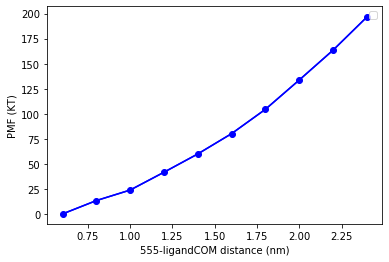

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(bin_centers, f_i,"o-", c='b')
plt.errorbar(bin_centers, f_i, yerr=df_i, c='b')
plt.xlabel('555-ligandCOM distance (nm)')
plt.ylabel('PMF (KT)')
plt.legend()
plt.show()